In [117]:
# import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [118]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Data

First, we read in the data, dropping the index and the date.

In [119]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
df=df.drop(columns=['ARIMA'])
df=df[800:]

We identify the dependent and independent variables:

In [120]:
target = "Close"

In [121]:
features = list(df.columns.difference(["Close"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

## Data processing for time series model

To process the data, we first define few terms

In [122]:
torch.manual_seed(42)
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [123]:
close_min=min(df['Close'].values)
close_max=max(df['Close'].values)

In [124]:
close_min

4993.9

In [125]:
close_max

8014.3

In [126]:
a=-1
b=1
normalized_df_2=(b-a)*((df-df.min())/(df.max()-df.min()))+a

In [127]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [128]:
df['Close']=normalized_df_2['Close']

In [129]:
df

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
800,-0.664382,-0.518756,-0.212867,-0.376660,-2.096023,-0.541526,-0.618721,0.089789,1.732245,-0.477768,...,2.765372,-0.923083,-0.285174,-0.957418,0.029832,-0.442130,-0.376660,-0.460099,0.479939,-0.664382
801,-0.646763,-0.405198,-0.255201,-0.392525,-1.648446,-0.526270,-0.600796,0.096212,1.732245,-0.510207,...,2.765372,-0.947383,-0.387140,-1.015113,-0.059456,-0.471115,-0.392525,-0.463963,-0.746811,-0.646763
802,-0.651849,-0.315221,-0.292326,-0.409164,-1.448674,-0.518568,-0.605967,0.094358,1.742954,-0.537690,...,2.671345,-0.935746,-0.466173,-1.005142,-0.147868,-0.500101,-0.409164,-0.467120,-0.835320,-0.651849
803,-0.695260,-0.219031,-0.333231,-0.428391,-1.458203,-0.511942,-0.650199,0.078533,1.607479,-0.568214,...,2.671345,-0.959704,-0.550693,-1.010594,-0.236759,-0.531275,-0.428391,-0.473782,0.314693,-0.695260
804,-0.813687,-0.091393,-0.390878,-0.457822,-1.732959,-0.507468,-0.771680,0.035360,1.580170,-0.615116,...,2.671345,-0.945671,-0.686218,-1.139791,-0.336992,-0.572362,-0.457822,-0.483073,-0.020605,-0.813687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,0.764009,-0.149978,0.687472,0.738442,0.156114,0.753486,0.755674,0.610515,1.389541,0.775099,...,-0.713624,1.462017,-0.279086,0.658465,-0.531071,0.759355,0.738442,0.919877,-1.255627,0.764009
3135,0.792344,-0.320354,0.718714,0.721971,0.421769,0.683547,0.781440,0.620845,1.353128,0.781322,...,-0.807650,1.459964,-0.237484,0.628980,-0.476021,0.779237,0.721971,0.918719,-1.228554,0.792344
3136,0.858642,-0.360917,0.725812,0.717688,0.821349,0.666530,0.841517,0.645014,1.392218,0.798688,...,-0.807650,1.463044,-0.160380,0.692283,-0.415414,0.804912,0.717688,0.916662,-0.521709,0.858642
3137,0.892608,-0.370429,0.727517,0.716729,1.019851,0.662588,0.872183,0.657396,1.391683,0.819186,...,-0.807650,1.479814,-0.076886,0.758568,-0.348987,0.834026,0.716729,0.915488,-0.821082,0.892608


The last step in the data processing is to prepare the data in a sequence of past observations. Preparation of the time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance and window decides how many days we want to predict for. If the sequence length is $n$ and window is $w$, then the LSTM considers the last $n$ observations to predict the next $w$ day price.

In [130]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [131]:
# Data for regression model
sequence_length_reg = window_reg =20 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,5):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(460, 20, 24) (460, 20)


In [132]:
indices = tf.range(start=0, limit=tf.shape(X_reg)[0])
shuffled_indices = tf.random.shuffle(indices)

In [133]:
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [134]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (414, 20, 24) and (414, 20)
Shape os test is (46, 20, 24) and (46, 20)


In [135]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(8280, 24)
(8280,)


In [136]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(920, 24)
(920,)


In [137]:
# Prepare test data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg:len(df)- window_reg]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

In [138]:
X_check_reg

array([[ 1.05844214, -0.19716968,  0.75959957,  0.80516313,  1.21592729,
         0.81014498,  1.0208129 ,  1.05844214,  0.79302159,  0.8132752 ,
         0.85160002,  1.05832725, -0.80714765, -0.40596154,  0.00628931,
        -0.33751597,  1.66531029, -0.46132203,  1.0267621 , -0.85619257,
         0.69737467,  0.80516313,  1.07490531,  0.33719206],
       [ 1.16360979, -0.07160229,  0.73748563,  0.81858003,  1.46921145,
         0.86331144,  1.11414635,  1.16360979,  0.80266014,  0.88129793,
         0.88581386,  1.06690863, -0.81716517, -0.42146188, -0.01617262,
        -0.43154287,  1.63382382, -0.19384604,  1.47645234, -0.7267417 ,
         0.7646153 ,  0.81858003,  1.07164371, -0.57175877],
       [ 1.19557785,  0.06292609,  0.71762843,  0.83736927,  1.37200998,
         0.92509087,  1.14237711,  1.19557785,  0.87923305,  0.94287189,
         0.91992414,  1.07651383, -0.82718633, -0.43698916, -0.03872802,
        -0.43154287,  1.62013404,  0.03791227,  1.74878423, -0.57338238,
  

In [139]:
y_check_reg

array([0.56469342, 0.53377036, 0.50211892, 0.49907297, 0.5076811 ,
       0.54059065, 0.549265  , 0.55257582, 0.55257582, 0.63627334,
       0.64203417, 0.61912329, 0.63594226, 0.62819494, 0.6183287 ,
       0.61051516, 0.62084492, 0.64501391, 0.65739637, 0.65739637])

## ANN

In [140]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model

In [141]:
input_ = Input((len(features),)) # feature

den1=Dense(256, use_bias=True,activation='relu')(input_)

den2=Dense(128, use_bias=True,activation='relu')(den1)

den3=Dense(64, use_bias=True,activation='relu')(den2)

den4=Dense(32, use_bias=True,activation='relu')(den3)

den5=Dense(1, use_bias=True,activation='linear')(den4)

model = Model(inputs=[input_], outputs=den5)

In [142]:
import tensorflow as tf

In [143]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss=loss_fn)

In [144]:
model_history = model.fit(X_train_reg_, y_train_reg_,
                    validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=32, 
                   epochs=300, shuffle=True
                   )

Epoch 1/300
259/259 [==============================] - 2s 4ms/step - loss: 0.0262 - val_loss: 0.0113
Epoch 2/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 3/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 4/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 5/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 6/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 9/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 10/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0024 - val_lo

Epoch 79/300
259/259 [==============================] - 1s 3ms/step - loss: 4.4723e-04 - val_loss: 6.3313e-04
Epoch 80/300
259/259 [==============================] - 1s 3ms/step - loss: 6.3538e-04 - val_loss: 6.8265e-04
Epoch 81/300
259/259 [==============================] - 1s 3ms/step - loss: 4.7935e-04 - val_loss: 4.6889e-04
Epoch 82/300
259/259 [==============================] - 1s 3ms/step - loss: 5.5160e-04 - val_loss: 5.0896e-04
Epoch 83/300
259/259 [==============================] - 1s 3ms/step - loss: 6.7198e-04 - val_loss: 7.0934e-04
Epoch 84/300
259/259 [==============================] - 1s 3ms/step - loss: 5.7531e-04 - val_loss: 7.2759e-04
Epoch 85/300
259/259 [==============================] - 1s 3ms/step - loss: 5.2439e-04 - val_loss: 6.1647e-04
Epoch 86/300
259/259 [==============================] - 1s 3ms/step - loss: 4.6617e-04 - val_loss: 3.6977e-04
Epoch 87/300
259/259 [==============================] - 1s 2ms/step - loss: 5.7305e-04 - val_loss: 5.4924e-04
Epoch 88/3

259/259 [==============================] - 1s 3ms/step - loss: 2.5219e-04 - val_loss: 3.2374e-04
Epoch 154/300
259/259 [==============================] - 1s 3ms/step - loss: 2.5674e-04 - val_loss: 2.7160e-04
Epoch 155/300
259/259 [==============================] - 1s 3ms/step - loss: 4.1899e-04 - val_loss: 5.4253e-04
Epoch 156/300
259/259 [==============================] - 1s 3ms/step - loss: 4.1556e-04 - val_loss: 8.9067e-04
Epoch 157/300
259/259 [==============================] - 1s 3ms/step - loss: 3.4484e-04 - val_loss: 2.8213e-04
Epoch 158/300
259/259 [==============================] - 1s 3ms/step - loss: 3.3886e-04 - val_loss: 8.1429e-04
Epoch 159/300
259/259 [==============================] - 1s 3ms/step - loss: 3.0206e-04 - val_loss: 1.9480e-04
Epoch 160/300
259/259 [==============================] - 1s 3ms/step - loss: 2.1467e-04 - val_loss: 1.9039e-04
Epoch 161/300
259/259 [==============================] - 1s 3ms/step - loss: 1.9753e-04 - val_loss: 1.8013e-04
Epoch 162/300
2

Epoch 227/300
259/259 [==============================] - 1s 3ms/step - loss: 2.6542e-04 - val_loss: 1.8162e-04
Epoch 228/300
259/259 [==============================] - 1s 3ms/step - loss: 1.1400e-04 - val_loss: 1.6247e-04
Epoch 229/300
259/259 [==============================] - 1s 3ms/step - loss: 1.6967e-04 - val_loss: 1.5012e-04
Epoch 230/300
259/259 [==============================] - 1s 4ms/step - loss: 1.3976e-04 - val_loss: 1.5925e-04
Epoch 231/300
259/259 [==============================] - 1s 3ms/step - loss: 1.6158e-04 - val_loss: 1.6885e-04
Epoch 232/300
259/259 [==============================] - 1s 3ms/step - loss: 2.1044e-04 - val_loss: 2.3425e-04
Epoch 233/300
259/259 [==============================] - 1s 4ms/step - loss: 1.5397e-04 - val_loss: 2.4095e-04
Epoch 234/300
259/259 [==============================] - 1s 3ms/step - loss: 1.8977e-04 - val_loss: 2.9386e-04
Epoch 235/300
259/259 [==============================] - 1s 3ms/step - loss: 2.3654e-04 - val_loss: 1.5067e-04
E

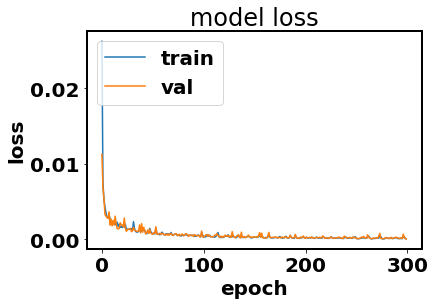

In [145]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [146]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5
    

In [147]:
a=-1
b=1

In [148]:
# Predict the model 
y_train_pred_ann = model.predict(X_train_reg_) 
mae_train_ann = mae_metric((((y_train_reg_-a)/(b-a))*(close_max - close_min)) + close_min, ((np.array(y_train_pred_ann)-a)/(b-a))*(close_max - close_min)+ close_min)
print('MAE train: ',mae_train_ann)
rmse_train_ann = rmse_metric((((y_train_reg_-a)/(b-a))*(close_max - close_min)) + close_min,((np.array(y_train_pred_ann)-a)/(b-a))*(close_max - close_min)+ close_min)
print('RMSE train: ',rmse_train_ann)

MAE train:  [9.313364]
RMSE train:  [13.756752]


In [149]:
# Predict the model 
y_test_pred_ann = model.predict(X_test_reg_) 
mae_test_ann = mae_metric((((y_test_reg_-a)/(b-a))*(close_max - close_min)) + close_min, ((np.array(y_test_pred_ann)-a)/(b-a))*(close_max - close_min)+ close_min)
print('MAE test: ',mae_test_ann)
rmse_test_ann = rmse_metric((((y_test_reg_-a)/(b-a))*(close_max - close_min)) + close_min,((np.array(y_test_pred_ann)-a)/(b-a))*(close_max - close_min)+ close_min)
print('RMSE test: ',rmse_test_ann)

MAE test:  [9.128418]
RMSE test:  [12.540112]


In [150]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_15 (Dense)            (None, 256)               6400      
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable

In [151]:
y_check_pred_nn = model.predict(X_check_reg)
y_check_pred_nn=y_check_pred_nn.flatten()
mae_test_ann = mae_metric((((y_check_reg-a)/(b-a))*(close_max - close_min)) + close_min, ((np.array(y_check_pred_nn)-a)/(b-a))*(close_max - close_min)+ close_min)
print('MAE test: ',mae_test_ann)
rmse_test_ann = rmse_metric((((y_check_reg-a)/(b-a))*(close_max - close_min)) + close_min,((np.array(y_check_pred_nn)-a)/(b-a))*(close_max - close_min)+ close_min)
print('RMSE test: ',rmse_test_ann)

MAE test:  17.86491210937488
RMSE test:  35.887291805469836


## Comparison

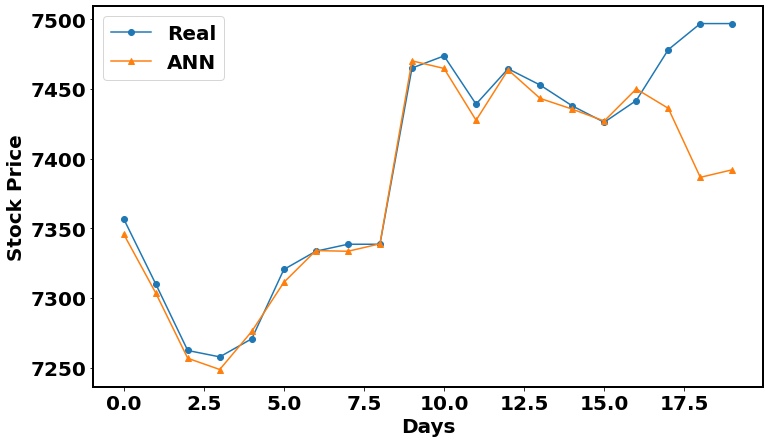

In [152]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(((((y_check_reg-a)/(b-a))*(close_max - close_min))+close_min), label = "Real",marker='o')
plt.plot( ( (((y_check_pred_nn-a)/(b-a))*(close_max - close_min))+close_min), label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

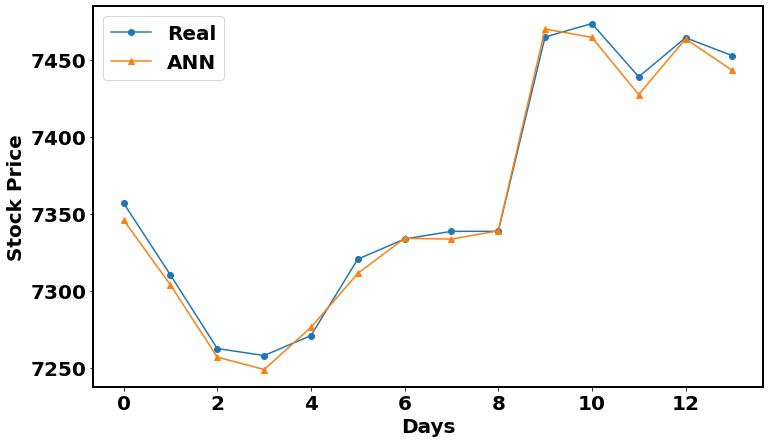

In [153]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(((((y_check_reg-a)/(b-a))*(close_max - close_min))+close_min)[:14], label = "Real",marker='o')
plt.plot( ( (((y_check_pred_nn-a)/(b-a))*(close_max - close_min))+close_min)[:14], label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()